In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

plt.style.use("default")
sns.set(style="whitegrid")

print("Imports loaded successfully.")


Imports loaded successfully.


In [2]:

BASE_DIR = os.path.abspath("..")

MODELS_DIR = os.path.join(BASE_DIR, "models")
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("BASE_DIR:   ", BASE_DIR)
print("MODELS_DIR: ", MODELS_DIR)
print("DATA_DIR:   ", DATA_DIR)
print("OUTPUT_DIR: ", OUTPUT_DIR)


BASE_DIR:    /Users/ramya/Downloads/Project DS
MODELS_DIR:  /Users/ramya/Downloads/Project DS/models
DATA_DIR:    /Users/ramya/Downloads/Project DS/data/processed
OUTPUT_DIR:  /Users/ramya/Downloads/Project DS/output


In [3]:

# 1. Load trained Random Forest model
model_path = os.path.join(MODELS_DIR, "random_forest_model.pkl")
rf_model = joblib.load(model_path)

# 2. Load X_test and y_test from parquet
X_test_path = os.path.join(DATA_DIR, "X_test.parquet")
y_test_path = os.path.join(DATA_DIR, "y_test.parquet")

X_test = pd.read_parquet(X_test_path)
y_test = pd.read_parquet(y_test_path)

# Convert y_test to a Series if it is a DataFrame
if isinstance(y_test, pd.DataFrame):
    if y_test.shape[1] == 1:
        y_test = y_test.iloc[:, 0]
    else:
        target_candidates = [c for c in y_test.columns if "total" in c.lower() or "fare" in c.lower()]
        if target_candidates:
            y_test = y_test[target_candidates[0]]
        else:
            raise ValueError("y_test has multiple columns and no clear target column.")

print(" Data & model loaded.")
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
print("Model type:  ", type(rf_model))

display(X_test.head())
display(y_test.head())


 Data & model loaded.
X_test.shape: (392034, 57)
y_test.shape: (392034,)
Model type:   <class 'sklearn.ensemble._forest.RandomForestRegressor'>


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,improvement_surcharge,Airport_fee,temperature_avg,...,dropoff_borough_EWR,dropoff_borough_Manhattan,dropoff_borough_Queens,dropoff_borough_Staten Island,traffic_volume_category_medium,time_of_day_factor_evening,time_of_day_factor_morning,time_of_day_factor_night,day_type_weekday,day_type_weekend
0,-1.657658,-1.511794,0.215248,-0.071962,-0.437754,1.396034,-0.460094,0.045215,0.0,0.605848,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.603261,-0.420499,0.811490,0.094282,-0.531552,-0.726728,-0.460094,0.045215,0.0,0.605848,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.603261,0.670796,-0.144961,-0.071962,1.094272,-1.268104,-0.460094,0.045215,0.0,0.605848,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.603261,0.670796,-0.108529,-0.071962,-0.046931,1.025619,1.732659,0.045215,0.0,0.605848,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.603261,-0.420499,-0.097241,-0.071962,1.000474,1.168087,-0.460094,0.045215,0.0,0.605848,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


0    32.4
1    70.0
2     7.9
3    11.4
4    13.5
Name: fare_amount, dtype: float64

In [4]:

y_pred = rf_model.predict(X_test)

print(" Predictions generated.")
print("y_pred.shape:", y_pred.shape)

print("\nPredicted fare stats:")
print("  min:", np.min(y_pred))
print("  max:", np.max(y_pred))
print("  mean:", np.mean(y_pred))

print("\nActual fare stats:")
print("  min:", y_test.min())
print("  max:", y_test.max())
print("  mean:", y_test.mean())

# Show sample
pd.DataFrame({
    "actual_fare": y_test.values[:10],
    "predicted_fare": y_pred[:10]
})


 Predictions generated.
y_pred.shape: (392034,)

Predicted fare stats:
  min: 2.9465136743886746
  max: 404.63365487012203
  mean: 17.875485788084816

Actual fare stats:
  min: 0.01
  max: 600.0
  mean: 17.87832320666065


,actual_fare,predicted_fare
0,32.4,32.653557
1,70.0,70.000000
2,7.9,7.251976
3,11.4,11.643515
4,13.5,13.583957
5,7.9,7.745591
6,15.6,16.626723
7,8.6,8.647690
8,12.8,13.092746
9,48.5,50.621354


In [5]:

# Avoid division by zero: replace very small predicted fares with a small epsilon
epsilon = 1e-6
safe_pred = np.where(y_pred <= 0, epsilon, y_pred)

hpi = y_test.values / safe_pred
residual = y_test.values - y_pred
residual_pct = residual / safe_pred * 100.0

results = pd.DataFrame({
    "actual_fare": y_test.values,
    "predicted_fare": y_pred,
    "hpi": hpi,
    "residual": residual,
    "residual_pct": residual_pct,
}, index=y_test.index)

print(" HPI & residuals calculated.")
print("results.shape:", results.shape)

# Basic HPI stats
print("\nHPI descriptive statistics:")
print(results["hpi"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]))

display(results.head(10))


 HPI & residuals calculated.
results.shape: (392034, 5)

HPI descriptive statistics:
count    392034.000000
mean          1.000454
std           0.061629
min           0.000140
25%           0.978118
50%           1.000000
75%           1.022606
95%           1.077212
99%           1.122029
max          11.221187
Name: hpi, dtype: float64


,actual_fare,predicted_fare,hpi,residual,residual_pct
0,32.4,32.653557,0.992235,-0.253557,-0.776507
1,70.0,70.000000,1.000000,0.000000,0.000000
2,7.9,7.251976,1.089358,0.648024,8.935833
3,11.4,11.643515,0.979086,-0.243515,-2.091420
4,13.5,13.583957,0.993819,-0.083957,-0.618063
5,7.9,7.745591,1.019935,0.154409,1.993508
6,15.6,16.626723,0.938249,-1.026723,-6.175140
7,8.6,8.647690,0.994485,-0.047690,-0.551477
8,12.8,13.092746,0.977641,-0.292746,-2.235942
9,48.5,50.621354,0.958094,-2.121354,-4.190630


In [6]:

threshold_conservative = 1.20   # 20% markup = unfair
threshold_moderate = 1.30       # 30% markup = unfair (default)
threshold_aggressive = 1.50     # 50% markup = extreme

results["is_unfair_conservative"] = (results["hpi"] > threshold_conservative).astype(int)
results["is_unfair_moderate"] = (results["hpi"] > threshold_moderate).astype(int)
results["is_unfair_aggressive"] = (results["hpi"] > threshold_aggressive).astype(int)

total_rides = len(results)

def _threshold_summary(name, mask):
    count = mask.sum()
    pct = count / total_rides * 100
    print(f"{name}: {count:,} rides ({pct:.2f}%)")
    return count, pct

print(" Unfair flags created.\n")
c_count, c_pct = _threshold_summary("Conservative (HPI > 1.20)", results["is_unfair_conservative"] == 1)
m_count, m_pct = _threshold_summary("Moderate    (HPI > 1.30)", results["is_unfair_moderate"] == 1)
a_count, a_pct = _threshold_summary("Aggressive  (HPI > 1.50)", results["is_unfair_aggressive"] == 1)

# Default threshold: moderate
results["is_unfair"] = results["is_unfair_moderate"]

unfair_mask = results["is_unfair"] == 1
unfair_count = unfair_mask.sum()
unfair_pct = unfair_count / total_rides * 100

total_overcharge = results.loc[unfair_mask, "residual"].sum()
avg_overcharge = results.loc[unfair_mask, "residual"].mean()
avg_overcharge_pct = results.loc[unfair_mask, "residual_pct"].mean()

print("\n Default threshold set to HPI > 1.30 (Moderate).")
print(f"Unfair rides (HPI > 1.30): {unfair_count:,} ({unfair_pct:.2f}%)")
print(f"Total overcharge (unfair rides): ${total_overcharge:,.2f}")
print(f"Average overcharge per unfair ride: ${avg_overcharge:,.2f}")
print(f"Average overcharge percentage: {avg_overcharge_pct:.2f}%")


 Unfair flags created.

Conservative (HPI > 1.20): 624 rides (0.16%)
Moderate    (HPI > 1.30): 327 rides (0.08%)
Aggressive  (HPI > 1.50): 148 rides (0.04%)

 Default threshold set to HPI > 1.30 (Moderate).
Unfair rides (HPI > 1.30): 327 (0.08%)
Total overcharge (unfair rides): $10,383.96
Average overcharge per unfair ride: $31.76
Average overcharge percentage: 77.41%


In [7]:

merged_path_candidates = [
    os.path.join(DATA_DIR, "taxi_weather_zones_merged_2023_sample.parquet"),
    os.path.join(DATA_DIR, "taxi_weather_zones_merged_2023_sample.csv"),
    os.path.join(DATA_DIR, "taxi_weather_zones_merged.parquet"),
    os.path.join(DATA_DIR, "taxi_weather_zones_merged.csv"),
]

merged_path = None
for p in merged_path_candidates:
    if os.path.exists(p):
        merged_path = p
        break

if merged_path is None:
    raise FileNotFoundError(
        "Could not find merged taxi-weather-zones file in DATA_DIR. "
        "Please adjust merged_path_candidates in this cell."
    )

print("Using merged file:", merged_path)

if merged_path.endswith(".parquet"):
    merged_df = pd.read_parquet(merged_path)
else:
    merged_df = pd.read_csv(merged_path)

print("merged_df.shape:", merged_df.shape)

n_test = len(results)
if len(merged_df) >= n_test:
    context_df = merged_df.tail(n_test).copy()
else:
    raise ValueError("Merged dataset has fewer rows than test set – please align them manually.")

context_df = context_df.reset_index(drop=True)
results = results.reset_index(drop=True)

# === Weather columns ===
# try to create 'temp_category' consistently
if "temp_category" in context_df.columns:
    results["temp_category"] = context_df["temp_category"]
elif "temperature_category" in context_df.columns:
    results["temp_category"] = context_df["temperature_category"]
else:
    print(" No temp_category / temperature_category in merged data. Filling as 'unknown'.")
    results["temp_category"] = "unknown"

if "is_raining" in context_df.columns:
    results["is_raining"] = context_df["is_raining"]
else:
    # If you have precipitation, create it:
    if "precipitation" in context_df.columns:
        results["is_raining"] = (context_df["precipitation"] > 0).astype(int)
    else:
        print("⚠️ No is_raining / precipitation column found. Filling 0.")
        results["is_raining"] = 0

# === Traffic / congestion ===
if "congestion_surcharge" in context_df.columns:
    results["congestion_surcharge"] = context_df["congestion_surcharge"]
else:
    print("⚠️ No congestion_surcharge column found. Filling 0.")
    results["congestion_surcharge"] = 0.0

# === Time features ===
# Try pickup datetime columns
pickup_cols = [c for c in context_df.columns if "pickup" in c.lower() and "datetime" in c.lower()]
if pickup_cols:
    pickup_col = pickup_cols[0]
    pickup_dt = pd.to_datetime(context_df[pickup_col])
    results["hour"] = pickup_dt.dt.hour
    results["day_of_week"] = pickup_dt.dt.weekday
else:
    # If not available, try to reuse any existing hour/day_of_week
    if "hour" in context_df.columns:
        results["hour"] = context_df["hour"]
    else:
        print("⚠️ No pickup datetime / hour column found. Filling hour = -1.")
        results["hour"] = -1

    if "day_of_week" in context_df.columns:
        results["day_of_week"] = context_df["day_of_week"]
    else:
        print("⚠️ No day_of_week column found. Filling -1.")
        results["day_of_week"] = -1

# === Zone info ===
zone_id_col = None
for cand in ["pickup_zone_id", "PULocationID", "zone_id"]:
    if cand in context_df.columns:
        zone_id_col = cand
        break

if zone_id_col is not None:
    results["zone_id"] = context_df[zone_id_col]
else:
    print("⚠️ No zone_id-like column found. Filling -1.")
    results["zone_id"] = -1

zone_name_col = None
for cand in ["pickup_zone_name", "zone_name", "Zone", "zone"]:
    if cand in context_df.columns:
        zone_name_col = cand
        break

if zone_name_col is not None:
    results["zone_name"] = context_df[zone_name_col].astype(str)
else:
    results["zone_name"] = "Zone " + results["zone_id"].astype(str)

print("\n Context columns added.")
print("results.shape:", results.shape)
print("Columns:", results.columns.tolist())
display(results.head())


Using merged file: /Users/ramya/Downloads/Project DS/data/processed/taxi_weather_zones_merged_2023_sample.parquet
merged_df.shape: (1960211, 29)

 Context columns added.
results.shape: (392034, 16)
Columns: ['actual_fare', 'predicted_fare', 'hpi', 'residual', 'residual_pct', 'is_unfair_conservative', 'is_unfair_moderate', 'is_unfair_aggressive', 'is_unfair', 'temp_category', 'is_raining', 'congestion_surcharge', 'hour', 'day_of_week', 'zone_id', 'zone_name']


,actual_fare,predicted_fare,hpi,residual,residual_pct,is_unfair_conservative,is_unfair_moderate,is_unfair_aggressive,is_unfair,temp_category,is_raining,congestion_surcharge,hour,day_of_week,zone_id,zone_name
0,32.4,32.653557,0.992235,-0.253557,-0.776507,0,0,0,0,normal,1.0,2.5,9,2,163,Zone 163
1,70.0,70.000000,1.000000,0.000000,0.000000,0,0,0,0,normal,1.0,2.5,9,2,162,Zone 162
2,7.9,7.251976,1.089358,0.648024,8.935833,0,0,0,0,normal,1.0,2.5,9,2,249,Zone 249
3,11.4,11.643515,0.979086,-0.243515,-2.091420,0,0,0,0,normal,1.0,2.5,9,2,138,Zone 138
4,13.5,13.583957,0.993819,-0.083957,-0.618063,0,0,0,0,normal,1.0,2.5,9,2,237,Zone 237


In [8]:

median_congestion = results["congestion_surcharge"].median()
unfair_mask = results["is_unfair"] == 1

normal_conditions_mask = (results["temp_category"] == "normal") & \
                         (results["congestion_surcharge"] <= median_congestion)

bad_conditions_mask = (results["temp_category"] != "normal") | \
                      (results["congestion_surcharge"] > median_congestion)

unjustified_mask = unfair_mask & normal_conditions_mask

justified_mask = unfair_mask & bad_conditions_mask

fair_mask = results["is_unfair"] == 0

unjustified_count = unjustified_mask.sum()
justified_count = justified_mask.sum()
fair_count = fair_mask.sum()
total = len(results)

print("Justified vs Unjustified breakdown")
print(f"Total rides: {total:,}")
print(f"Fair pricing (HPI ≤ {threshold_moderate:.2f}): {fair_count:,} ({fair_count/total*100:.2f}%)")
print(f"Justified surcharges (HPI > {threshold_moderate:.2f} & bad conditions): "
      f"{justified_count:,} ({justified_count/total*100:.2f}%)")
print(f"Unjustified surcharges (HPI > {threshold_moderate:.2f} & normal conditions): "
      f"{unjustified_count:,} ({unjustified_count/total*100:.2f}%)")

print("\n Most suspicious rides (likely manipulation):", f"{unjustified_count:,}")


Justified vs Unjustified breakdown
Total rides: 392,034
Fair pricing (HPI ≤ 1.30): 391,707 (99.92%)
Justified surcharges (HPI > 1.30 & bad conditions): 0 (0.00%)
Unjustified surcharges (HPI > 1.30 & normal conditions): 327 (0.08%)

 Most suspicious rides (likely manipulation): 327


In [9]:

zone_group = results.groupby(["zone_id", "zone_name"], as_index=False)

zone_summary = zone_group.agg(
    total_rides=("hpi", "count"),
    unfair_count=("is_unfair", "sum"),
    avg_hpi=("hpi", "mean"),
    avg_overcharge_unfair=("residual", lambda x: x[results.loc[x.index, "is_unfair"] == 1].mean()
                           if (results.loc[x.index, "is_unfair"] == 1).any() else 0.0),
    total_overcharge_unfair=("residual", lambda x: x[results.loc[x.index, "is_unfair"] == 1].sum())
)

zone_summary["unfair_rate"] = zone_summary["unfair_count"] / zone_summary["total_rides"]

zone_summary = zone_summary.sort_values("unfair_rate", ascending=False)

zone_csv_path = os.path.join(OUTPUT_DIR, "hpi_zone_analysis.csv")
zone_parquet_path = os.path.join(OUTPUT_DIR, "hpi_zone_analysis.parquet")

zone_summary.to_csv(zone_csv_path, index=False)
zone_summary.to_parquet(zone_parquet_path, index=False)

print("Zone summary saved to:")
print(" -", zone_csv_path)
print(" -", zone_parquet_path)

print("\nTop 25 zones by unfair_rate:")
display(zone_summary.head(25))

high_risk_zones = zone_summary[zone_summary["unfair_rate"] > 0.10]
print("\nZones with unfair_rate > 10% (high risk):")
display(high_risk_zones)

# Some key zones
if not zone_summary.empty:
    worst_rate_zone = zone_summary.iloc[0]
    most_unfair_count_zone = zone_summary.sort_values("unfair_count", ascending=False).iloc[0]
    most_total_overcharge_zone = zone_summary.sort_values("total_overcharge_unfair", ascending=False).iloc[0]

    print("\nWorst by unfair_rate:")
    print(worst_rate_zone)

    print("\nMost unfair rides (count):")
    print(most_unfair_count_zone)

    print("\nHighest total overcharge:")
    print(most_total_overcharge_zone)


Zone summary saved to:
 - /Users/ramya/Downloads/Project DS/output/hpi_zone_analysis.csv
 - /Users/ramya/Downloads/Project DS/output/hpi_zone_analysis.parquet

Top 25 zones by unfair_rate:


,zone_id,zone_name,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,total_overcharge_unfair,unfair_rate
196,220,Zone 220,9,1,1.033470,15.613330,15.613330,0.111111
181,205,Zone 205,16,1,1.024279,16.783248,16.783248,0.062500
160,181,Zone 181,79,1,1.007465,20.291135,20.291135,0.012658
9,12,Zone 12,88,1,1.006795,9.694072,9.694072,0.011364
112,130,Zone 130,109,1,1.003554,19.269753,19.269753,0.009174
5,7,Zone 7,142,1,1.006902,7.678298,7.678298,0.007042
100,116,Zone 116,252,1,1.003028,111.488312,111.488312,0.003968
208,232,Zone 232,324,1,1.003845,18.046637,18.046637,0.003086
2,4,Zone 4,380,1,1.002878,4.849991,4.849991,0.002632
79,88,Zone 88,899,2,1.003898,23.483094,46.966189,0.002225



Zones with unfair_rate > 10% (high risk):


,zone_id,zone_name,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,total_overcharge_unfair,unfair_rate
196,220,Zone 220,9,1,1.03347,15.61333,15.61333,0.111111



Worst by unfair_rate:
zone_id                         220
zone_name                  Zone 220
total_rides                       9
unfair_count                      1
avg_hpi                     1.03347
avg_overcharge_unfair      15.61333
total_overcharge_unfair    15.61333
unfair_rate                0.111111
Name: 196, dtype: object

Most unfair rides (count):
zone_id                           161
zone_name                    Zone 161
total_rides                     18868
unfair_count                       18
avg_hpi                      0.999913
avg_overcharge_unfair       36.682741
total_overcharge_unfair    660.289329
unfair_rate                  0.000954
Name: 142, dtype: object

Highest total overcharge:
zone_id                           132
zone_name                    Zone 132
total_rides                     15999
unfair_count                       18
avg_hpi                      1.001457
avg_overcharge_unfair       51.638574
total_overcharge_unfair    929.494324
unfair_rate   

In [10]:

hour_group = results.groupby("hour", as_index=False)

hour_summary = hour_group.agg(
    total_rides=("hpi", "count"),
    unfair_count=("is_unfair", "sum"),
    avg_hpi=("hpi", "mean"),
    avg_overcharge_unfair=("residual", lambda x: x[results.loc[x.index, "is_unfair"] == 1].mean()
                           if (results.loc[x.index, "is_unfair"] == 1).any() else 0.0),
)

hour_summary["unfair_rate"] = hour_summary["unfair_count"] / hour_summary["total_rides"]

hour_summary = hour_summary.sort_values("hour")

hour_csv_path = os.path.join(OUTPUT_DIR, "hpi_hour_analysis.csv")
hour_parquet_path = os.path.join(OUTPUT_DIR, "hpi_hour_analysis.parquet")

hour_summary.to_csv(hour_csv_path, index=False)
hour_summary.to_parquet(hour_parquet_path, index=False)

print(" Hour summary saved to:")
print(" -", hour_csv_path)
print(" -", hour_parquet_path)

print("\nUnfair rate by hour (0-23):")
display(hour_summary)

# Top 5 hours by unfair_rate
top_hours = hour_summary.sort_values("unfair_rate", ascending=False).head(5)
print("\nTop 5 hours with highest unfair_rate:")
display(top_hours)

# Some simple observations
late_night_hours = hour_summary[hour_summary["hour"].isin([22, 23, 0, 1, 2, 3, 4])]
rush_hours = hour_summary[hour_summary["hour"].isin([7, 8, 9, 17, 18, 19])]

print("\nLate night hours (22-4):")
display(late_night_hours)

print("\nRush hours (7-9, 17-19):")
display(rush_hours)


 Hour summary saved to:
 - /Users/ramya/Downloads/Project DS/output/hpi_hour_analysis.csv
 - /Users/ramya/Downloads/Project DS/output/hpi_hour_analysis.parquet

Unfair rate by hour (0-23):


,hour,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,unfair_rate
0,0,9391,7,1.000270,43.962572,0.000745
1,1,6371,3,0.999291,14.459177,0.000471
2,2,4297,2,1.000485,69.680077,0.000465
3,3,2705,0,1.002412,0.000000,0.000000
4,4,1573,1,1.000553,39.719069,0.000636
5,5,1598,1,0.998413,36.794946,0.000626
6,6,3811,2,0.998078,40.982547,0.000525
7,7,7999,2,0.998889,34.904884,0.000250
8,8,11208,7,0.998412,29.298244,0.000625
9,9,15017,12,0.999014,28.408276,0.000799



Top 5 hours with highest unfair_rate:


,hour,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,unfair_rate
18,18,30023,40,1.001781,42.328727,0.001332
16,16,26211,31,1.002719,31.080634,0.001183
22,22,17544,19,1.002113,22.881862,0.001083
17,17,28223,30,1.000628,26.622413,0.001063
23,23,13187,14,1.002106,16.186577,0.001062



Late night hours (22-4):


,hour,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,unfair_rate
0,0,9391,7,1.000270,43.962572,0.000745
1,1,6371,3,0.999291,14.459177,0.000471
2,2,4297,2,1.000485,69.680077,0.000465
3,3,2705,0,1.002412,0.000000,0.000000
4,4,1573,1,1.000553,39.719069,0.000636
22,22,17544,19,1.002113,22.881862,0.001083
23,23,13187,14,1.002106,16.186577,0.001062



Rush hours (7-9, 17-19):


,hour,total_rides,unfair_count,avg_hpi,avg_overcharge_unfair,unfair_rate
7,7,7999,2,0.998889,34.904884,0.000250
8,8,11208,7,0.998412,29.298244,0.000625
9,9,15017,12,0.999014,28.408276,0.000799
17,17,28223,30,1.000628,26.622413,0.001063
18,18,30023,40,1.001781,42.328727,0.001332
19,19,28149,21,1.001749,22.709290,0.000746


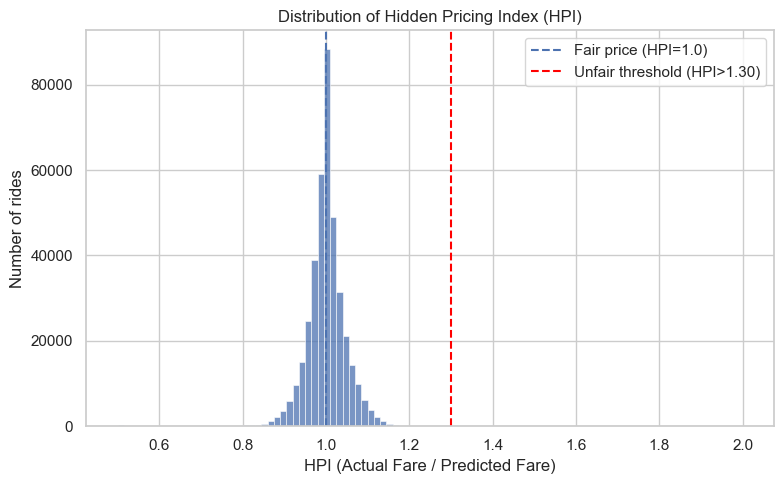

In [11]:

fig, ax = plt.subplots(figsize=(8, 5))

hpi_clip = results["hpi"].clip(0.5, 2.0)

sns.histplot(hpi_clip, bins=100, kde=False, ax=ax)

ax.axvline(1.0, linestyle="--", label="Fair price (HPI=1.0)")
ax.axvline(threshold_moderate, color="red", linestyle="--",
           label=f"Unfair threshold (HPI>{threshold_moderate:.2f})")

ax.set_title("Distribution of Hidden Pricing Index (HPI)")
ax.set_xlabel("HPI (Actual Fare / Predicted Fare)")
ax.set_ylabel("Number of rides")
ax.legend()

plt.tight_layout()
plt.show()


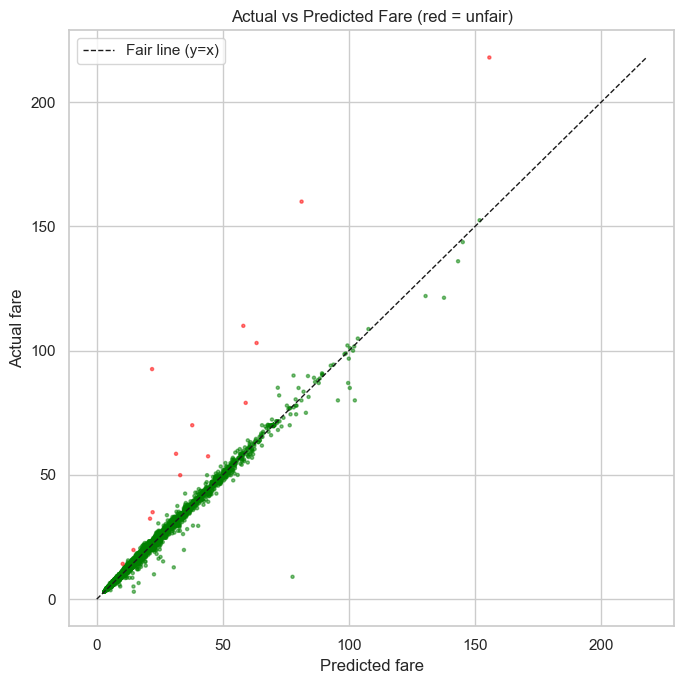

In [12]:

sample_size = min(10000, len(results))
sample_df = results.sample(sample_size, random_state=42).copy()

colors = np.where(sample_df["is_unfair"] == 1, "red", "green")

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(sample_df["predicted_fare"],
           sample_df["actual_fare"],
           s=5, alpha=0.5, c=colors)

max_fare = max(sample_df["predicted_fare"].max(), sample_df["actual_fare"].max())
ax.plot([0, max_fare], [0, max_fare], "k--", linewidth=1, label="Fair line (y=x)")

ax.set_title("Actual vs Predicted Fare (red = unfair)")
ax.set_xlabel("Predicted fare")
ax.set_ylabel("Actual fare")
ax.legend()

plt.tight_layout()
plt.show()


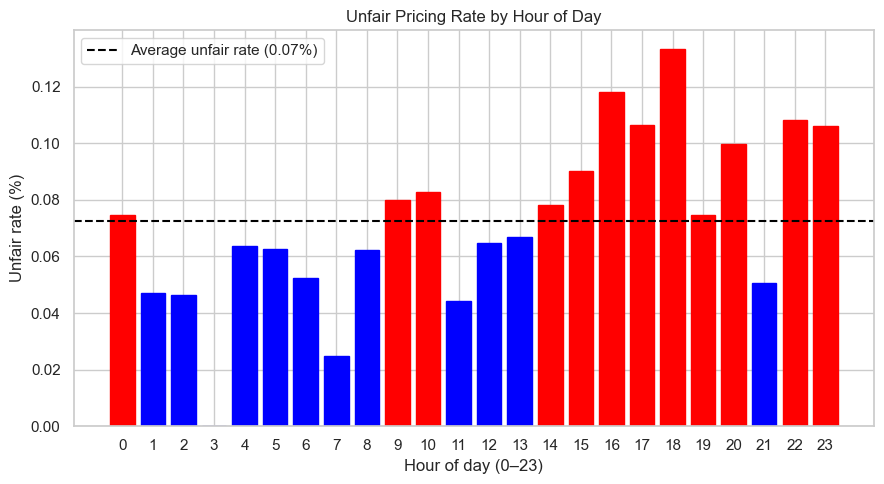

In [13]:

avg_unfair_rate = hour_summary["unfair_rate"].mean()

fig, ax = plt.subplots(figsize=(9, 5))

bars = ax.bar(hour_summary["hour"], hour_summary["unfair_rate"] * 100)

for bar, rate in zip(bars, hour_summary["unfair_rate"]):
    if rate > avg_unfair_rate:
        bar.set_color("red")
    else:
        bar.set_color("blue")

ax.axhline(avg_unfair_rate * 100, color="black", linestyle="--",
           label=f"Average unfair rate ({avg_unfair_rate*100:.2f}%)")

ax.set_title("Unfair Pricing Rate by Hour of Day")
ax.set_xlabel("Hour of day (0–23)")
ax.set_ylabel("Unfair rate (%)")
ax.set_xticks(range(0, 24))
ax.legend()

plt.tight_layout()
plt.show()


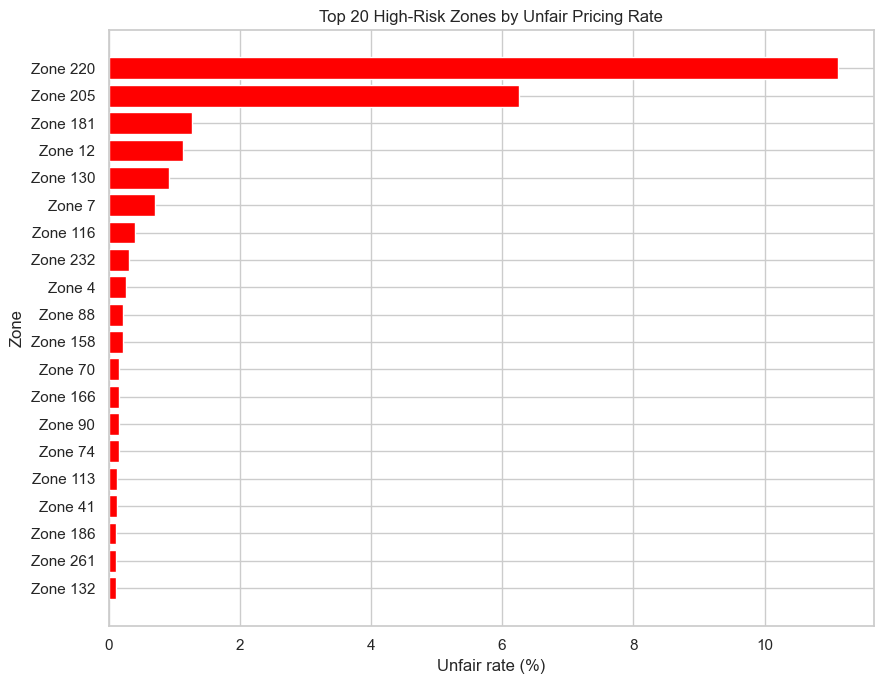

In [14]:

top_zones = zone_summary.sort_values("unfair_rate", ascending=False).head(20)
top_zones = top_zones.sort_values("unfair_rate")  

fig, ax = plt.subplots(figsize=(9, 7))

ax.barh(top_zones["zone_name"], top_zones["unfair_rate"] * 100, color="red")
ax.set_title("Top 20 High-Risk Zones by Unfair Pricing Rate")
ax.set_xlabel("Unfair rate (%)")
ax.set_ylabel("Zone")
plt.tight_layout()
plt.show()


In [15]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. HPI histogram
hpi_clip = results["hpi"].clip(0.5, 2.0)
sns.histplot(hpi_clip, bins=50, kde=False, ax=axes[0, 0])
axes[0, 0].axvline(1.0, linestyle="--", label="Fair (HPI=1.0)")
axes[0, 0].axvline(threshold_moderate, color="red", linestyle="--",
                   label=f"Unfair (>{threshold_moderate:.2f})")
axes[0, 0].set_title("HPI Distribution")
axes[0, 0].legend()

# 2. Scatter actual vs predicted (sample)
sample_df = results.sample(min(8000, len(results)), random_state=42)
colors = np.where(sample_df["is_unfair"] == 1, "red", "green")
axes[0, 1].scatter(sample_df["predicted_fare"],
                   sample_df["actual_fare"],
                   s=4, alpha=0.5, c=colors)
max_fare = max(sample_df["predicted_fare"].max(), sample_df["actual_fare"].max())
axes[0, 1].plot([0, max_fare], [0, max_fare], "k--", linewidth=1)
axes[0, 1].set_title("Actual vs Predicted Fare")
axes[0, 1].set_xlabel("Predicted fare")
axes[0, 1].set_ylabel("Actual fare")

# 3. Unfair rate by hour
axes[1, 0].bar(hour_summary["hour"], hour_summary["unfair_rate"] * 100)
axes[1, 0].axhline(hour_summary["unfair_rate"].mean() * 100,
                   color="black", linestyle="--", linewidth=1)
axes[1, 0].set_title("Unfair Rate by Hour")
axes[1, 0].set_xlabel("Hour")
axes[1, 0].set_ylabel("Unfair rate (%)")

# 4. Top high-risk zones
tz = zone_summary.sort_values("unfair_rate", ascending=False).head(10)
tz = tz.sort_values("unfair_rate")
axes[1, 1].barh(tz["zone_name"], tz["unfair_rate"] * 100, color="red")
axes[1, 1].set_title("Top 10 High-Risk Zones")
axes[1, 1].set_xlabel("Unfair rate (%)")

plt.tight_layout()

dashboard_path = os.path.join(OUTPUT_DIR, "hpi_comprehensive_analysis.png")
plt.savefig(dashboard_path, dpi=300)
plt.close(fig)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.barh(tz["zone_name"], tz["unfair_rate"] * 100, color="red")
ax2.set_title("Top 10 High-Risk Zones by Unfair Rate")
ax2.set_xlabel("Unfair rate (%)")
plt.tight_layout()

zone_viz_path = os.path.join(OUTPUT_DIR, "hpi_zone_analysis_viz.png")
plt.savefig(zone_viz_path, dpi=300)
plt.close(fig2)

print("Dashboard and zone visualization saved:")
print(" -", dashboard_path)
print(" -", zone_viz_path)


Dashboard and zone visualization saved:
 - /Users/ramya/Downloads/Project DS/output/hpi_comprehensive_analysis.png
 - /Users/ramya/Downloads/Project DS/output/hpi_zone_analysis_viz.png


In [16]:

hpi_stats = results["hpi"].describe(percentiles=[0.95, 0.99])
mean_hpi = hpi_stats["mean"]
median_hpi = hpi_stats["50%"]
std_hpi = hpi_stats["std"]
min_hpi = hpi_stats["min"]
max_hpi = hpi_stats["max"]
p95 = hpi_stats["95%"]
p99 = hpi_stats["99%"]

conservative_mask = results["hpi"] > threshold_conservative
moderate_mask = results["hpi"] > threshold_moderate
aggressive_mask = results["hpi"] > threshold_aggressive

cons_count = conservative_mask.sum()
cons_pct = cons_count / total_rides * 100

mod_count = moderate_mask.sum()
mod_pct = mod_count / total_rides * 100

aggr_count = aggressive_mask.sum()
aggr_pct = aggr_count / total_rides * 100

unjustified_mask = (results["is_unfair"] == 1) & \
                   (results["temp_category"] == "normal") & \
                   (results["congestion_surcharge"] <= median_congestion)
unjustified_count = unjustified_mask.sum()

report_path = os.path.join(OUTPUT_DIR, "hpi_detection_report.txt")

with open(report_path, "w") as f:
    f.write("HIDDEN PRICING INDEX (HPI) ANALYSIS REPORT\n")
    f.write("Fair Ride Fare Manipulation Detection System\n")
    f.write("=" * 80 + "\n\n")

    # Executive summary
    f.write("[SECTION 2: EXECUTIVE SUMMARY]\n")
    f.write(f"Total rides analyzed: {total_rides:,}\n")
    f.write(f"Unfair rides detected (HPI > {threshold_moderate:.2f}): "
            f"{unfair_count:,} ({unfair_pct:.2f}%)\n")
    f.write(f"Total overcharge detected: ${total_overcharge:,.2f}\n")
    f.write(f"Average overcharge per unfair ride: ${avg_overcharge:,.2f}\n")
    f.write(f"Average overcharge percentage: {avg_overcharge_pct:.2f}%\n\n")

    # HPI stats
    f.write("[SECTION 3: HPI STATISTICS]\n")
    f.write(f"Mean HPI: {mean_hpi:.4f}\n")
    f.write(f"Median HPI: {median_hpi:.4f}\n")
    f.write(f"Std Dev: {std_hpi:.4f}\n")
    f.write(f"Min: {min_hpi:.4f}\n")
    f.write(f"Max: {max_hpi:.4f}\n")
    f.write(f"95th percentile: {p95:.4f}\n")
    f.write(f"99th percentile: {p99:.4f}\n\n")

    # Threshold section
    f.write("[SECTION 4: UNFAIR PRICING THRESHOLDS]\n")
    f.write(f"Conservative (HPI > {threshold_conservative:.2f}): "
            f"{cons_count:,} rides ({cons_pct:.2f}%)\n")
    f.write(f"Moderate    (HPI > {threshold_moderate:.2f}): "
            f"{mod_count:,} rides ({mod_pct:.2f}%)\n")
    f.write(f"Aggressive  (HPI > {threshold_aggressive:.2f}): "
            f"{aggr_count:,} rides ({aggr_pct:.2f}%)\n\n")

    # Top 20 zones
    f.write("[SECTION 5: TOP 20 HIGH-RISK ZONES]\n")
    for _, row in zone_summary.sort_values("unfair_rate", ascending=False).head(20).iterrows():
        f.write(
            f"Zone {row['zone_id']} ({row['zone_name']}): "
            f"{int(row['total_rides']):,} rides, "
            f"{int(row['unfair_count']):,} unfair "
            f"({row['unfair_rate']*100:.2f}%), "
            f"avg HPI {row['avg_hpi']:.3f}\n"
        )
    f.write("\n")

    # Peak hours
    f.write("[SECTION 6: PEAK MANIPULATION HOURS]\n")
    for _, row in hour_summary.sort_values("unfair_rate", ascending=False).iterrows():
        f.write(
            f"Hour {int(row['hour']):02d}: "
            f"{int(row['total_rides']):,} rides, "
            f"{int(row['unfair_count']):,} unfair "
            f"({row['unfair_rate']*100:.2f}%), "
            f"avg HPI {row['avg_hpi']:.3f}\n"
        )
    f.write("\n")

    # Key findings
    f.write("[SECTION 7: KEY FINDINGS]\n")
    f.write(f"- About {unfair_pct:.2f}% of rides are priced above fair by more than 30%.\n")
    if not zone_summary.empty:
        worst_zone = zone_summary.iloc[0]
        f.write(f"- The highest-risk zone by unfair rate is Zone {worst_zone['zone_id']} "
                f"({worst_zone['zone_name']}) with "
                f"{worst_zone['unfair_rate']*100:.2f}% unfair rides.\n")
    if not hour_summary.empty:
        worst_hour = hour_summary.sort_values("unfair_rate", ascending=False).iloc[0]
        f.write(f"- The highest-risk hour is {int(worst_hour['hour']):02d}:00 with "
                f"{worst_hour['unfair_rate']*100:.2f}% unfair rides.\n")
    f.write(f"- Total detected overcharge across unfair rides is about "
            f"${total_overcharge:,.2f}.\n")
    f.write(f"- Unjustified surcharges under normal conditions: "
            f"{unjustified_count:,} rides (most suspicious).\n\n")

    f.write("[SECTION 8: RECOMMENDATIONS]\n")
    f.write("- Investigate pricing behaviour in high-risk zones with elevated HPI.\n")
    f.write("- Increase monitoring during peak manipulation hours identified above.\n")
    f.write("- Review congestion/weather-based surcharges for rides flagged as unfair.\n")
    f.write("- Consider customer refunds or audits for unjustified surcharges.\n")

print("Text report saved to:", report_path)


Text report saved to: /Users/ramya/Downloads/Project DS/output/hpi_detection_report.txt


In [17]:

full_results_path = os.path.join(OUTPUT_DIR, "hpi_complete_results.parquet")
results.to_parquet(full_results_path, index=False)

high_risk_zones = zone_summary[zone_summary["unfair_rate"] > 0.10]
num_high_risk_zones = len(high_risk_zones)

top3_zones = zone_summary.sort_values("unfair_rate", ascending=False).head(3)
top3_hours = hour_summary.sort_values("unfair_rate", ascending=False).head(3)

print("=" * 60)
print("HPI DETECTION SUMMARY")
print("=" * 60)
print(f"Total rides analyzed: {total_rides:,}")
print(f"Unfair rides (HPI > {threshold_moderate:.2f}): {unfair_count:,} ({unfair_pct:.2f}%)")
print(f"Total overcharge detected: ${total_overcharge:,.2f}")
print(f"Average overcharge per unfair ride: ${avg_overcharge:,.2f}\n")

print(f"High-risk zones: {num_high_risk_zones} zones with >10% unfair rate\n")

print("Top 3 most suspicious zones (by unfair rate):")
for _, row in top3_zones.iterrows():
    print(f"- Zone {row['zone_id']} ({row['zone_name']}): "
          f"{row['unfair_rate']*100:.2f}% unfair rate")

print("\nPeak manipulation hours (Top 3 by unfair rate):")
for _, row in top3_hours.iterrows():
    print(f"- Hour {int(row['hour']):02d}: "
          f"{row['unfair_rate']*100:.2f}% unfair, "
          f"{int(row['unfair_count']):,} unfair rides")

print(f"\nUnjustified surcharges (likely manipulation): {unjustified_count:,} rides")
print("=" * 60)

print("\nOutput files created in OUTPUT_DIR:")
print("hpi_zone_analysis.csv")
print("hpi_hour_analysis.csv")
print("hpi_zone_analysis.parquet")
print("hpi_hour_analysis.parquet")
print("hpi_complete_results.parquet")
print("hpi_comprehensive_analysis.png")
print("hpi_zone_analysis_viz.png")
print("hpi_detection_report.txt")
print("HIDDEN PRICING INDEX ANALYSIS - COMPLETE ")


HPI DETECTION SUMMARY
Total rides analyzed: 392,034
Unfair rides (HPI > 1.30): 327 (0.08%)
Total overcharge detected: $10,383.96
Average overcharge per unfair ride: $31.76

High-risk zones: 1 zones with >10% unfair rate

Top 3 most suspicious zones (by unfair rate):
- Zone 220 (Zone 220): 11.11% unfair rate
- Zone 205 (Zone 205): 6.25% unfair rate
- Zone 181 (Zone 181): 1.27% unfair rate

Peak manipulation hours (Top 3 by unfair rate):
- Hour 18: 0.13% unfair, 40 unfair rides
- Hour 16: 0.12% unfair, 31 unfair rides
- Hour 22: 0.11% unfair, 19 unfair rides

Unjustified surcharges (likely manipulation): 327 rides

Output files created in OUTPUT_DIR:
hpi_zone_analysis.csv
hpi_hour_analysis.csv
hpi_zone_analysis.parquet
hpi_hour_analysis.parquet
hpi_complete_results.parquet
hpi_comprehensive_analysis.png
hpi_zone_analysis_viz.png
hpi_detection_report.txt
HIDDEN PRICING INDEX ANALYSIS - COMPLETE 
